In [21]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Exercise description

For this project, let’s try to find a model that uses US treasury rates to describe the deposit rate paid.<br>
Deposit rate paid is the interest (expense) paid by banks to their depositors. Relevant data for all FDICinsured institutions can be found from the following link. https://www.fdic.gov/bank/analytical/qbp/

## Warm up

### Data cleaning

In [96]:
rates = os.listdir('US Treasury rates/')
rates = [rate.replace('.csv', '') for rate in rates]
rates.remove('Resampled')
print(rates)

['DGS1', 'DGS10', 'DGS1MO', 'DGS2', 'DGS20', 'DGS30', 'DGS3MO', 'DGS5', 'DGS6MO', 'DGS7']


The first step is to make explanatory data cohesive by using the same frequency. 

In [97]:
for rate in rates:
    df = pd.read_csv('US Treasury rates/' + rate +'.csv', index_col='DATE', parse_dates=True)
    df[df[rate]=='.'] = np.nan
    df[rate] = df[rate].astype(float)
    df = df.resample(rule='Q').mean()
    df.to_csv('US Treasury rates/Resampled/' + rate +'.csv') # save a resampled file

In [98]:
#df = pd.read_csv('US Treasury rates/Resampled/DGS1' +'.csv', index_col='DATE', parse_dates=True)

Let's create a single dataframe with all independent variables.

In [99]:
df_exp = pd.DataFrame()
for rate in rates:
    df = pd.read_csv('US Treasury rates/Resampled/' + rate +'.csv', index_col='DATE', parse_dates=True)
    df_exp = pd.concat([df_exp, df], axis = 1)
df_exp

,DGS1,DGS10,DGS1MO,DGS2,DGS20,DGS30,DGS3MO,DGS5,DGS6MO,DGS7
DATE,,,,,,,,,,
1962-03-31,3.202258,4.016290,NaN,NaN,NaN,NaN,NaN,3.835161,NaN,NaN
1962-06-30,3.014444,3.875714,NaN,NaN,NaN,NaN,NaN,3.631429,NaN,NaN
1962-09-30,3.187778,3.989524,NaN,NaN,NaN,NaN,NaN,3.739365,NaN,NaN
1962-12-31,2.993607,3.902459,NaN,NaN,NaN,NaN,NaN,3.599672,NaN,NaN
1963-03-31,3.027869,3.892131,NaN,NaN,NaN,NaN,NaN,3.638852,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2017-06-30,1.125714,2.260952,0.773016,1.297619,2.632857,2.896984,0.908095,1.811111,1.035079,2.072540
2017-09-30,1.243492,2.241429,0.981746,1.362698,2.576349,2.817460,1.053968,1.813492,1.142222,2.062540
2017-12-31,1.550323,2.371452,1.094839,1.694355,2.616452,2.816774,1.226613,2.069194,1.376129,2.248065


In [100]:
#df = pd.read_csv('US Treasury rates/DGS1' +'.csv', index_col='DATE', parse_dates=True)

In [101]:
# df[df['DGS1']=='.'] = np.nan
# df['DSG1'] = df['DGS1'].astype(float) 

In [102]:
# df = df.resample(rule='Q').mean()

### Desposit rate

**Domestic deposits interest-bearing was chosen as the appropriate balance column.** Noninterest-bearing balance was exluded at the start because it does not yield any interest. It is not certain if foreign deposits are interest bearing. Interest-bearing and noninterest-bearing might be added together. What is more, if foreign deposits were used as a denominator than deposit rate would be too large to be reasonable.

In [103]:
df2 = pd.read_excel('Deposit Interest.xlsx', index_col='YYYYQQ', parse_dates=True)
# calculation of Deposit rate paid was already calculated in excel. Deposit rate is expressed in percentage (multiplied by 100).

In [104]:
df2 = df2.resample(rule='Q').mean()

In [105]:
data = pd.concat([df_exp, df2['Deposit rate paid']], axis=1)
data

,DGS1,DGS10,DGS1MO,DGS2,DGS20,DGS30,DGS3MO,DGS5,DGS6MO,DGS7,Deposit rate paid
DATE,,,,,,,,,,,
1962-03-31,3.202258,4.016290,NaN,NaN,NaN,NaN,NaN,3.835161,NaN,NaN,NaN
1962-06-30,3.014444,3.875714,NaN,NaN,NaN,NaN,NaN,3.631429,NaN,NaN,NaN
1962-09-30,3.187778,3.989524,NaN,NaN,NaN,NaN,NaN,3.739365,NaN,NaN,NaN
1962-12-31,2.993607,3.902459,NaN,NaN,NaN,NaN,NaN,3.599672,NaN,NaN,NaN
1963-03-31,3.027869,3.892131,NaN,NaN,NaN,NaN,NaN,3.638852,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2017-06-30,1.125714,2.260952,0.773016,1.297619,2.632857,2.896984,0.908095,1.811111,1.035079,2.072540,0.201373
2017-09-30,1.243492,2.241429,0.981746,1.362698,2.576349,2.817460,1.053968,1.813492,1.142222,2.062540,0.228588
2017-12-31,1.550323,2.371452,1.094839,1.694355,2.616452,2.816774,1.226613,2.069194,1.376129,2.248065,0.239077


<AxesSubplot:title={'center':'Potential explanatory variables and Deposit Paid Rate'}, xlabel='DATE'>

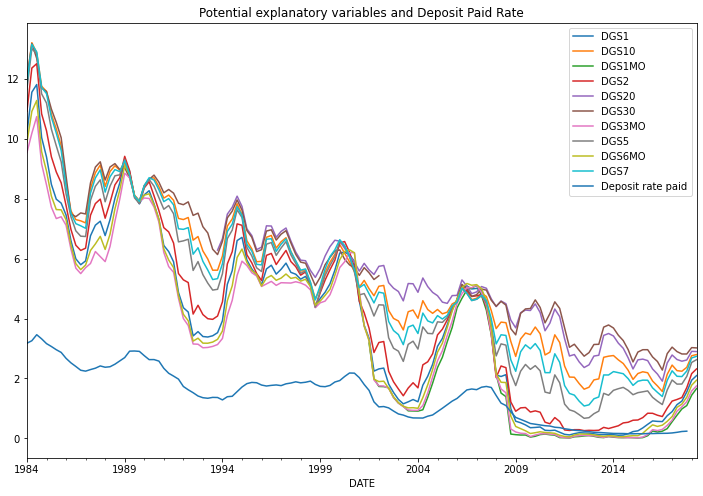

In [106]:
data['1984-01-01':].plot(figsize=(12,8), title='Potential explanatory variables and Deposit Paid Rate')

It is expected that Deposit rate is lower than other rates throughout the whole period. Deposits are paid on demand and other rates contain a time premium.

In [107]:
# Let's see how deposit rate correlates with potential explanatory variables
data.corr().sort_values('Deposit rate paid', ascending=False)['Deposit rate paid']

Deposit rate paid    1.000000
DGS3MO               0.974150
DGS6MO               0.972312
DGS1                 0.970169
DGS2                 0.968256
DGS5                 0.956637
DGS7                 0.949683
DGS10                0.939010
DGS30                0.915456
DGS1MO               0.902958
DGS20                0.863249
Name: Deposit rate paid, dtype: float64

It is expected that shorter maturity bonds (except 1-month DGS) are more correlated with deposit paid rate. Deposits are paid on demand which means that they are more likely to be financed with shorter term borrowing. In consequence, their rates should correlate more. We should be looking at shorter term rates first when choosing potential explanatory variables.

In [108]:
data = data[data['Deposit rate paid'].notna()]
print(f'There are quarters {len(data)} (which is {round(len(data)/4)} years) in the dataset for the dependent variable.')

There are quarters 136 (which is 34 years) in the dataset for the dependent variable.


## Feature engineering

In [109]:
# Let's see how many NAs are in each column 
data[data['Deposit rate paid'].notna()].isna().sum()

DGS1                  0
DGS10                 0
DGS1MO               70
DGS2                  0
DGS20                39
DGS30                15
DGS3MO                0
DGS5                  0
DGS6MO                0
DGS7                  0
Deposit rate paid     0
dtype: int64

In [110]:
data.drop(columns=['DGS1MO', 'DGS20', 'DGS30'], inplace=True)

Variables which have more than 10% of missing values (14 observations) can be excluded from the potential explanatory variables set. It could be considered to use variables with a shorter time frame to forecast Deposit rate as an extension of the exercise.

In [111]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

Adding lags of variables which will be later used for forecasting.<br>
We will add 5 lags to have the first lag and a lag a year earlier (1+4) to check for seasonality.

In [112]:
lags = range(1, 2)

X = X.assign(**{
    f'{col} (t-{lag})': X[col].shift(lag)
    for lag in lags
    for col in X
})

In [113]:
for col in X.loc[:,'DGS1':'DGS7']:
    X[col + '_rm'] = X[col].rolling(window=4).mean()
# let's also add rolling mean of each variable with lag(1).
# We can't use rolling mean of t=0 variables as it would be useless for forecasting.  

In [114]:
#data = pd.concat([X.loc[:,'DGS1 (t-1)':], y], axis=1)
data = pd.concat([X, y], axis=1)
data.dropna(inplace=True); data

,DGS1,DGS10,DGS2,DGS3MO,DGS5,DGS6MO,DGS7,DGS1 (t-1),DGS10 (t-1),DGS2 (t-1),...,DGS6MO (t-1),DGS7 (t-1),DGS1_rm,DGS10_rm,DGS2_rm,DGS3MO_rm,DGS5_rm,DGS6MO_rm,DGS7_rm,Deposit rate paid
DATE,,,,,,,,,,,,,,,,,,,,,
1984-12-31,10.047049,11.760656,10.838689,9.164918,11.506721,9.575574,11.720984,11.816984,12.873175,12.512857,...,11.283333,12.904127,10.903345,12.450579,11.660722,9.911094,12.253515,10.414209,12.413728,3.323010
1985-03-31,9.398333,11.586500,10.275000,8.464667,11.197833,8.925833,11.513000,10.047049,11.760656,10.838689,...,9.575574,11.720984,10.705711,12.358575,11.498303,9.640809,12.139909,10.175788,12.325083,3.163808
1985-06-30,8.480476,10.823492,9.401587,7.720476,10.325556,8.089841,10.724127,9.398333,11.586500,10.275000,...,8.925833,11.513000,9.935711,11.760956,10.757033,9.023944,11.466377,9.468645,11.715559,3.067167
1985-09-30,7.986032,10.335556,8.896032,7.340317,9.771429,7.640476,10.196190,8.480476,10.823492,9.401587,...,8.089841,10.724127,8.977973,11.126551,9.852827,8.172595,10.700385,8.557931,11.038575,2.959791
1985-12-31,7.856452,9.766129,8.534516,7.400000,9.236774,7.631935,9.620161,7.986032,10.335556,8.896032,...,7.640476,10.196190,8.430323,10.627919,9.276784,7.731365,10.132898,8.072022,10.513370,2.869714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,0.755738,2.138689,1.009508,0.433279,1.614754,0.567377,1.935410,0.559375,1.564375,0.728125,...,0.439844,1.396875,0.615587,1.841871,0.836278,0.320357,1.338413,0.464119,1.638461,0.168966
2017-03-31,0.892581,2.446613,1.244355,0.606129,1.947903,0.727742,2.255484,0.755738,2.138689,1.009508,...,0.567377,1.935410,0.693486,1.974958,0.938310,0.399266,1.482930,0.533350,1.780692,0.180224
2017-06-30,1.125714,2.260952,1.297619,0.908095,1.811111,1.035079,2.072540,0.892581,2.446613,1.244355,...,0.727742,2.255484,0.833352,2.102657,1.069902,0.561446,1.625591,0.692511,1.915077,0.201373


## Modelling

<AxesSubplot:title={'center':'Deposit Paid Rate'}, xlabel='DATE'>

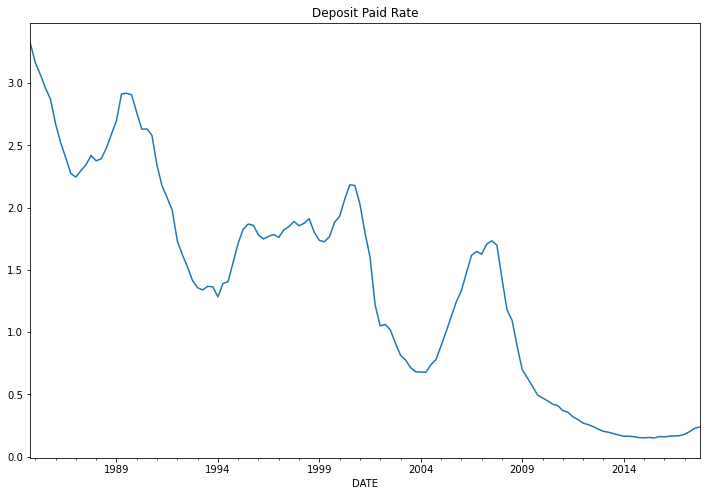

In [115]:
title='Deposit Paid Rate'
data['Deposit rate paid']['1984-01-01':].plot(figsize=(12,8), title=title)

We can see on the chart that the deposit rate is driven to a large extent by historic events like Dot-com Bubble (early 2000s) and Great Financial Crisis (from 2008 on). There is a 40 year downward trend in interest rates in the USA and Deposit rate follows this pattern.

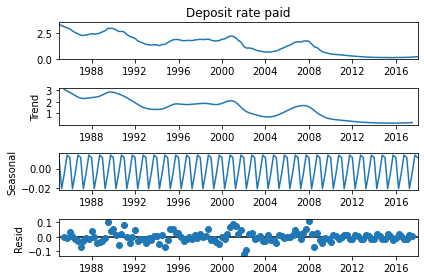

In [116]:
result = seasonal_decompose(data[data['Deposit rate paid'].notna()]['Deposit rate paid'])
result.plot();

Set 6 quarters for testing. It's not a lot of observations to check the quality of the model but the data is quite coarse (quarters) so we can't afford to make a long forecast window if the data changes dynamically as in case of Deposit Paid rate.

In [117]:
print(f'Dataset length is {len(data)}')

train = data.iloc[:119,:]
test = data.iloc[119:,:]
print(f'Train dataset length is {len(train)}')
print(f'Test dataset length is {len(test)} which makes it {round(len(test)*100/len(train),1)}% of the whole dataset \nIt means that we are going to forecast next {len(test)/4} years')

Dataset length is 133
Train dataset length is 119
Test dataset length is 14 which makes it 11.8% of the whole dataset 
It means that we are going to forecast next 3.5 years


We do not observe much of seasonality in the data which points to seasonal component being of lesser importance. Furthermore, seasonal decomposition above confirms that seasonality is very small compared to the overall downward trend. Nonetheless, we will check if a seasonal model is suitable.

### Model 1 - SARIMAX (ARIMA + exogenous variables)

For a start let's pick a SARIMA model with exogenous variables. It is a standard model for time series forecasting which might serve as a useful benchmark for a more advanced method.

In [136]:
# auto_arima function works for us to find the right:
# - autoregressive component
# - moving average component
# - order of differentiation (to remove non-stationarity)
auto_arima(data['Deposit rate paid'],seasonal=True,m=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  133
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 4)   Log Likelihood                 169.975
Date:                             Thu, 01 Jul 2021   AIC                           -331.949
Time:                                     12:12:26   BIC                           -320.418
Sample:                                          0   HQIC                          -327.264
                                             - 133                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7375      0.043     17.264      0.000       0.654       0.821
ar.S.L4        0.9919      0.025     39.994      0.000       0.943       1.040
ma.S.L4       -0.9492      0.085    -11.226      0.000      -1.115      -0.783
sigma2         0.0043      0.000      8.950      0.000       0.003       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                22.63
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.66
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's fit a SARIMAX(1, 1, 0) model with a seasonal component.<br>
Please bear in mind that the time series is not stationary and the second parametr of SARIMAX is 1 which means that first differences will be used in the model.

In [137]:
model = SARIMAX(train['Deposit rate paid'],exog=train.iloc[:,:-1],order=(1,1,0), seasonal_order=(1, 0, 0, 4), enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                 Deposit rate paid   No. Observations:                  119
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 4)   Log Likelihood                 219.153
Date:                           Thu, 01 Jul 2021   AIC                           -390.306
Time:                                   12:12:28   BIC                           -323.810
Sample:                               12-31-1984   HQIC                          -363.307
                                    - 06-30-2014                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
DGS1            -0.1438      0.163     -0.880      0.379      -0.464       0.176
DGS10            0.1498      0.145      1.036      0.300      -0.134       0.433
DGS2             0.0578      0.145      0.400      0.689      -0.226       0.341
DGS3MO          -0.0859      0.106     -0.813      0.416      -0.293       0.121
DGS5            -0.1754      0.208     -0.843      0.399      -0.583       0.232
DGS6MO           0.2631      0.180      1.460      0.144      -0.090       0.616
DGS7            -0.0232      0.246     -0.094      0.925      -0.504       0.458
DGS1 (t-1)      -0.2985      0.173     -1.729      0.084      -0.637       0.040
DGS10 (t-1)      0.0863      0.144      0.600      0.548      -0.195       0.368
DGS2 (t-1)       0.2998      0.106      2.836      0.005       0.093       0.507
DGS3MO (t-1)     0.0553      0.107      0.519      0.604      -0.154       0.264
DGS5 (t-1)      -0.1434      0.178     -0.808      0.419      -0.491       0.204
DGS6MO (t-1)     0.0691      0.167      0.413      0.679      -0.258       0.397
DGS7 (t-1)      -0.0267      0.246     -0.108      0.914      -0.510       0.456
DGS1_rm          0.0727      0.513      0.142      0.887      -0.932       1.078
DGS10_rm        -0.4750      0.369     -1.287      0.198      -1.199       0.249
DGS2_rm         -0.2340      0.400     -0.585      0.558      -1.017       0.549
DGS3MO_rm        0.1346      0.289      0.466      0.641      -0.431       0.701
DGS5_rm          0.3666      0.500      0.733      0.463      -0.613       1.346
DGS6MO_rm        0.0315      0.509      0.062      0.951      -0.965       1.028
DGS7_rm          0.2685      0.554      0.485      0.628      -0.817       1.354
ar.L1            0.1197      0.125      0.957      0.339      -0.125       0.365
ar.S.L4          0.2066      0.125      1.654      0.098      -0.038       0.452
sigma2           0.0014      0.000      7.863      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.96
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looking at the results above we can make the following observations:
- **lags higher than 1 are not statistically significant** (they were deleted fron the model) for any variable (p-value < 0.05). It means that higher (than 1) lags do not carry with it information which is useful for forecasting. It might be explained by a fact that that there is some downward trend in the data but the variation around it seems to be big. Hence, past values carry with them low informational value.
- The **autoregressive component is not statistically significant**. The same is true for seasonal components (AR and MA). 
- The only variable which is statistitically significant is lag (1) of **DGS2**. Our initial hypothesis of shorter term rates being correlated more with Deposit rate is not upheld.
- Rolling mean variables turn out to be statistically insignificant

In [139]:
results.pvalues < 0.05
# only pvalues < 0.05 are statistically significant

DGS1            False
DGS10           False
DGS2            False
DGS3MO          False
DGS5            False
DGS6MO          False
DGS7            False
DGS1 (t-1)      False
DGS10 (t-1)     False
DGS2 (t-1)       True
DGS3MO (t-1)    False
DGS5 (t-1)      False
DGS6MO (t-1)    False
DGS7 (t-1)      False
DGS1_rm         False
DGS10_rm        False
DGS2_rm         False
DGS3MO_rm       False
DGS5_rm         False
DGS6MO_rm       False
DGS7_rm         False
ar.L1           False
ar.S.L4         False
sigma2           True
dtype: bool

In [124]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test.iloc[:,:-1]  
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1, 1, 0)x(1, 0, [1], 4) Predictions')

[Text(0.5, 0, ''), Text(0, 0.5, 'percent')]

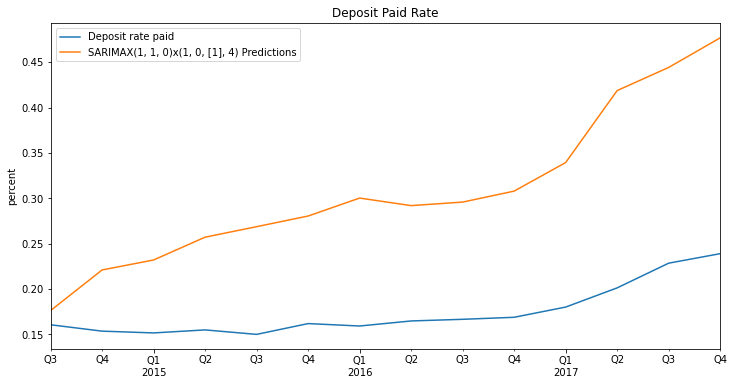

In [125]:
# Plot predictions against known values
title='Deposit Paid Rate'
ylabel='percent'
xlabel=''

ax = test['Deposit rate paid'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [126]:
error1 = mse(test['Deposit rate paid'], predictions)
error2 = rmse(test['Deposit rate paid'], predictions)
# Print SARIMAX values
print(f'SARIMAX(1,1,0)(1,0,1,4) MSE Error: {error1:11.10}')
print(f'SARIMAX(1,1,0)(1,0,1,4) RMSE Error: {error2:11.10}')

SARIMAX(1,1,0)(1,0,1,4) MSE Error: 0.02125491142
SARIMAX(1,1,0)(1,0,1,4) RMSE Error: 0.1457906424


If we want to have a useful model let's try to make it more operational by simplifying it. Furthermore, usually be reducing the number of variables we can reduce overfitting. Let's check how a simplified model is going to compare

In [127]:
#model = SARIMAX(train['Deposit rate paid'],exog=train[['DGS2 (t-1)', 'DGS3MO (t-1)']],order=(1,1,0), seasonal_order=(1, 0, 1, 4), enforce_invertibility=False)
model = SARIMAX(train['Deposit rate paid'],exog=train[['DGS2 (t-1)']],order=(1,1,0), seasonal_order=(1, 0, 1, 4), enforce_invertibility=False)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                   Deposit rate paid   No. Observations:                  119
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 4)   Log Likelihood                 156.389
Date:                             Thu, 01 Jul 2021   AIC                           -302.777
Time:                                     12:08:51   BIC                           -288.924
Sample:                                 12-31-1984   HQIC                          -297.152
                                      - 06-30-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DGS2 (t-1)     0.0613      0.014      4.254      0.000       0.033       0.089
ar.L1          0.6623      0.052     12.797      0.000       0.561       0.764
ar.S.L4        0.9902      0.035     28.466      0.000       0.922       1.058
ma.S.L4       -0.9505      0.100     -9.536      0.000      -1.146      -0.755
sigma2         0.0040      0.000      9.593      0.000       0.003       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):                22.98
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.63
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [129]:
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['DGS2 (t-1)']]
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Reduced SARIMAX(1,1,0) Predictions')
error1 = mse(test['Deposit rate paid'], predictions)
error2 = rmse(test['Deposit rate paid'], predictions)
# Print SARIMAX values
print(f'SARIMAX(1,1,0)(1,0,1,4) MSE Error: {error1:11.10}')
print(f'SARIMAX(1,1,0)(1,0,1,4) RMSE Error: {error2:11.10}')

SARIMAX(1,1,0)(1,0,1,4) MSE Error: 0.01238552886
SARIMAX(1,1,0)(1,0,1,4) RMSE Error: 0.111290291


[Text(0.5, 0, ''), Text(0, 0.5, 'percent')]

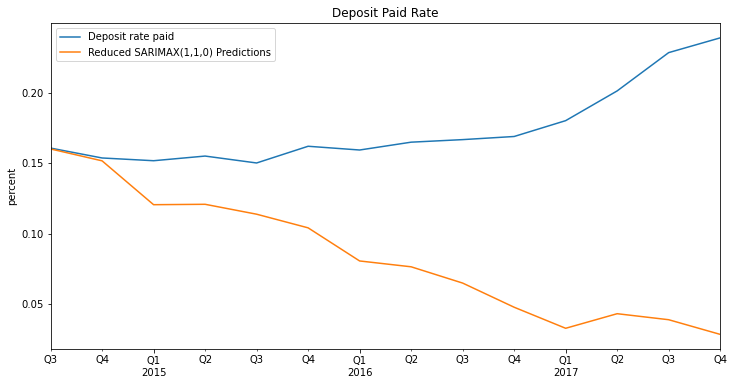

In [130]:
# Plot predictions against known values
title='Deposit Paid Rate'
ylabel='percent'
xlabel=''

ax = test['Deposit rate paid'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

We can see that information critera of both models are sort of similar, but the latter model performs better on unseen data (smaller MSE and RMSE). It means that we have successfully reduced overfitting, which can be expected when using lots of variables as in the first model.

In [132]:
# model = SARIMAX(train['Deposit rate paid'],exog=train['DGS3MO (t-1)'],order=(1,1,0), seasonal_order=(1, 0, 1, 4), enforce_invertibility=False)
# results = model.fit()
# results.summary()

In [133]:
# start=len(train)
# end=len(train)+len(test)-1
# exog_forecast = test['DGS3MO (t-1)']
# predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Reduced SARIMAX(1,1,0) Predictions')
# error1_best = mse(test['Deposit rate paid'], predictions)
# error2_best = rmse(test['Deposit rate paid'], predictions)
# # Print SARIMAX values
# print(f'SARIMAX(1,1,0)(1,0,1,4) MSE Error: {error1:11.10}')
# print(f'SARIMAX(1,1,0)(1,0,1,4) RMSE Error: {error2:11.10}')

In [134]:
# RMSE and MSE of models with and without DGS2 (t-1) are very similar which means that the simpler model should have a preference. We are going to choose the last model as the final SARIMAX model. Now it should be compared to a more advanced, machine learning model. Finally, let's visualize it to see how the predictions look against the whole dataset.  

[Text(0.5, 0, ''), Text(0, 0.5, 'percent')]

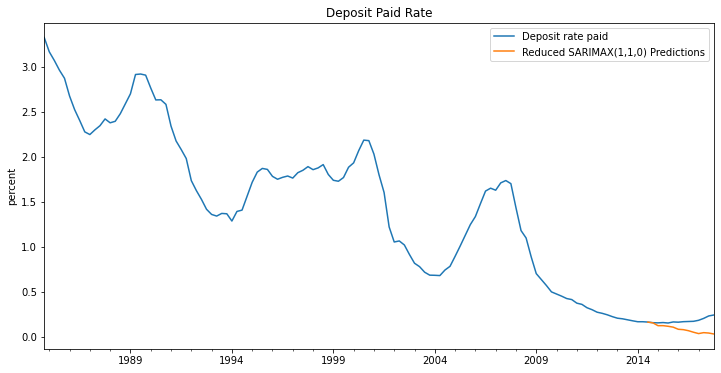

In [131]:
title='Deposit Paid Rate'
ylabel='percent'
xlabel=''

ax = data['Deposit rate paid'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

Clearly our model expects lower interest rates that in reality. 

In [220]:
# Let's extend our work and see if adding a variable which was initially relevant at 0.1 level would improve the predictions

In [140]:
model = SARIMAX(train['Deposit rate paid'],exog=train[['DGS2 (t-1)', 'DGS1 (t-1)']],order=(1,1,0), seasonal_order=(1, 0, 1, 4), enforce_invertibility=False)
results = model.fit()
results.summary()
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['DGS2 (t-1)', 'DGS1 (t-1)']]
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Reduced SARIMAX(1,1,0) Predictions')
error1 = mse(test['Deposit rate paid'], predictions)
error2 = rmse(test['Deposit rate paid'], predictions)
# Print SARIMAX values
print(f'SARIMAX(1,1,0)(1,0,1,4) MSE Error: {error1:11.10}')
print(f'SARIMAX(1,1,0)(1,0,1,4) RMSE Error: {error2:11.10}')


SARIMAX(1,1,0)(1,0,1,4) MSE Error: 0.009417270093
SARIMAX(1,1,0)(1,0,1,4) RMSE Error: 0.09704261998


[Text(0.5, 0, ''), Text(0, 0.5, 'percent')]

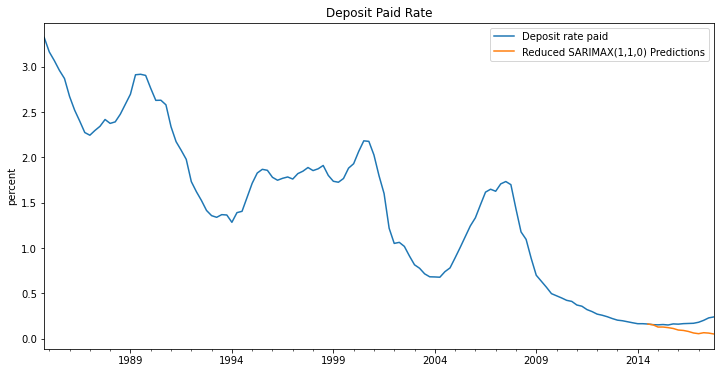

In [141]:
title='Deposit Paid Rate'
ylabel='percent'
xlabel=''

ax = data['Deposit rate paid'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

Indeed, it does improve it. It means that a possible extension of the exercise would involved adding next variables to check model quality.

### Model 2 - Neural Network

To compare the results we obtained from SARIMAX model, let's see how a neural network (NN) would perform. <br>There are 2 obvious disadvanages of using a NN:
<br>a) the model has many parameters and we have a quite short time series. There is some risk that the model would fit the data very well (overfit) and do not extend that well on new data.
<br>b) NN is a 'black box' model which has poorer explainability

In [154]:
# data needs to be normalized before feeding a neural Network
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
print(scaled.shape)

train = scaled[:119, :]
test = scaled[119:, :]

X_train = train[:,:-1]
y_train = train[:,-1]
X_test = test[:,:-1]
y_test = test[:,-1]

(133, 22)


In [155]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(119, 1, 21) (119,) (14, 1, 21) (14,)


Epoch 1/10
3/3 - 5s - loss: 0.3732 - val_loss: 0.0182
Epoch 2/10
3/3 - 0s - loss: 0.3295 - val_loss: 0.0287
Epoch 3/10
3/3 - 0s - loss: 0.2870 - val_loss: 0.0393
Epoch 4/10
3/3 - 0s - loss: 0.2448 - val_loss: 0.0499
Epoch 5/10
3/3 - 0s - loss: 0.2034 - val_loss: 0.0604
Epoch 6/10
3/3 - 0s - loss: 0.1624 - val_loss: 0.0707
Epoch 7/10
3/3 - 0s - loss: 0.1222 - val_loss: 0.0808
Epoch 8/10
3/3 - 0s - loss: 0.0854 - val_loss: 0.0905
Epoch 9/10
3/3 - 0s - loss: 0.0580 - val_loss: 0.0990
Epoch 10/10
3/3 - 0s - loss: 0.0470 - val_loss: 0.1052


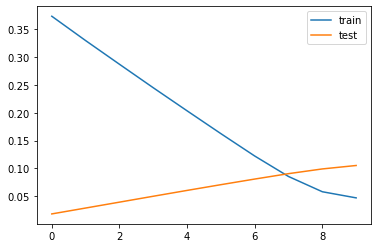

In [164]:
model = Sequential()
model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2]))) # values of the LTSM parameter tried: 10, 20, 30, 40, 60
# 50 gave the best result
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=10, batch_size=40, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [165]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2])) # back to the normal shape
print(X_test.shape)

(14, 21)


In [166]:
print(yhat.shape)
print(X_test.shape)

(14, 1)
(14, 21)


In [167]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
predictions = inv_yhat[:,0]

In [168]:
predictions

array([1.19481572, 1.16538482, 1.09182662, 1.07610705, 1.10997764,
       1.14539995, 1.14348194, 1.08808425, 1.01506942, 1.09800267,
       1.34253623, 1.46959708, 1.54749644, 1.66140444])

In [169]:
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
#inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = np.concatenate((y_test, X_test), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate MSE & RMSE
rmse = np.sqrt(mean_squared_error(inv_y, predictions))
mse = mean_squared_error(inv_y, predictions)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)

Test MSE: 1.107
Test RMSE: 1.052


In [184]:
# Let's create a function to run the NN more easily
def run_nn(data=data, ltsm=30, n_epochs=15, batch=40):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)

    train = scaled[:119, :]
    test = scaled[119:, :]

    X_train = train[:,:-1]
    y_train = train[:,-1]
    X_test = test[:,:-1]
    y_test = test[:,-1]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    model = Sequential()
    model.add(LSTM(ltsm, input_shape=(X_train.shape[1], X_train.shape[2]))) # values of the LTSM parameter tried: 10, 20, 30, 40, 60
    # 50 gave the best result
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch, validation_data=(X_test, y_test), verbose=False, shuffle=False)
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    yhat = model.predict(X_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[2])) # back to the normal shape
    inv_yhat = np.concatenate((yhat, X_test), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    predictions = inv_yhat[:,0]

    # invert scaling for actual
    y_test = y_test.reshape((len(y_test), 1))
    #inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
    inv_y = np.concatenate((y_test, X_test), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate MSE & RMSE
    rmse = np.sqrt(mean_squared_error(inv_y, predictions))
    mse = mean_squared_error(inv_y, predictions)
    print('Test MSE: %.5f' % mse)
    print('Test RMSE: %.5f' % rmse)
    return mse, rmse, predictions

In [179]:
#run_nn(data, n_epochs=50)

Epoch 1/15
3/3 - 5s - loss: 0.4300 - val_loss: 0.0424
Epoch 2/15
3/3 - 0s - loss: 0.4145 - val_loss: 0.0335
Epoch 3/15
3/3 - 0s - loss: 0.3996 - val_loss: 0.0265
Epoch 4/15
3/3 - 0s - loss: 0.3851 - val_loss: 0.0220
Epoch 5/15
3/3 - 0s - loss: 0.3708 - val_loss: 0.0195
Epoch 6/15
3/3 - 0s - loss: 0.3567 - val_loss: 0.0197
Epoch 7/15
3/3 - 0s - loss: 0.3428 - val_loss: 0.0229
Epoch 8/15
3/3 - 0s - loss: 0.3290 - val_loss: 0.0275
Epoch 9/15
3/3 - 0s - loss: 0.3155 - val_loss: 0.0331
Epoch 10/15
3/3 - 0s - loss: 0.3021 - val_loss: 0.0396
Epoch 11/15
3/3 - 0s - loss: 0.2886 - val_loss: 0.0469
Epoch 12/15
3/3 - 0s - loss: 0.2750 - val_loss: 0.0556
Epoch 13/15
3/3 - 0s - loss: 0.2614 - val_loss: 0.0643
Epoch 14/15
3/3 - 0s - loss: 0.2477 - val_loss: 0.0729
Epoch 15/15
3/3 - 0s - loss: 0.2344 - val_loss: 0.0815


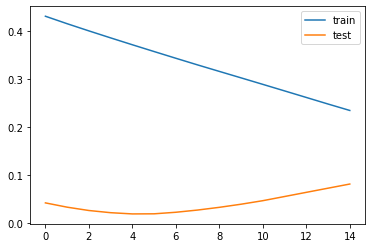

Test MSE: 0.78155
Test RMSE: 0.88405


(0.7815497858576909,
 0.8840530447081164,
 array([1.52791708, 1.534045  , 1.54303419, 1.55269616, 1.56037916,
        1.58169743, 1.59813067, 1.6033397 , 1.59634903, 1.61241522,
        1.65729948, 1.68318082, 1.70980824, 1.74515737]))

In [180]:
# let's pick only columns which turned out to be statistically significant at 0.1 level in SARIMA model
matchers = ['DGS1 ', 'DGS2']
matching = [s for s in data.columns if any(xs in s for xs in matchers)]
run_nn(data[matching])

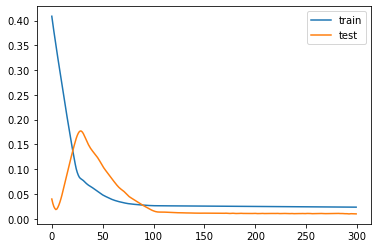

Test MSE: 0.01219
Test RMSE: 0.11039


(0.012185543509349897,
 0.11038814931572093,
 array([0.49291351, 0.53532362, 0.56879861, 0.61814323, 0.64335129,
        0.73013191, 0.82197545, 0.84321706, 0.80556715, 0.83896554,
        1.05174643, 1.19557933, 1.29978935, 1.42445338]))

In [187]:
matchers = ['DGS1 ', 'DGS2']
matching = [s for s in data.columns if any(xs in s for xs in matchers)]
run_nn(data[matching], n_epochs=300)

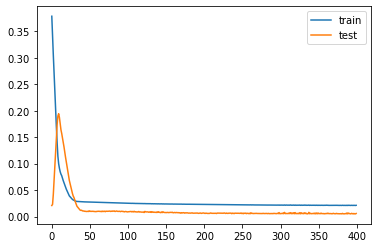

Test MSE: 0.00577
Test RMSE: 0.07595


In [186]:
# let's see if we can make the model even leaner and delete one variable which seemed to be the least correlated with Dep.Rate
matchers = ['DGS2']
matching = [s for s in data.columns if any(xs in s for xs in matchers)]
mse, rmse, predictions = run_nn(data[matching], n_epochs=400, batch=10) # number of epochs was selected so that validation loss is still smaller than train loss 

Test MSE of NN model is smaller than SARIMAX'es!

# 3 - Summary

A NN model with lagged values and rolling mean (also lagged) of two variables: DGS1 and DGS2 turned out to be the best predictor of Deposit Paid rate. SARIMAX model's performance was only slightly weaker. Strong performance of DGS2 variable was not expected from the start as it is not the most correlated with Deposit rate. <br> 
Final statistics for the model are the following:
<br>**Neural Network** RMSE Error: 0.09
<br>**SARIMAX**(1,1,0)(1,0,1,4) RMSE Error: 0.076

Possible extensions of the exercie:
- substracting variables from the final NN model. A leaner model would be preferable. 
- checking predictive ability of variables which had more than 10% of missing values. It is possible that they would add some predictive power despite being a shorter time series. 
- running the model on the whole dataset (train + test) to obtain predictions from the model for the future. 